FACIAL EXPRESSION RECOGNITION

Introduction

Detect face and classify the facial expression into seven universal facial expressions i.e anger, neutral, disgust, fear, joy, sadness, and surprise.

The dataset is sourced from Kaggle (https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset) which has approximately 36000 greyscale images of 48x48 pixels spread across 7 expression categories. The dataset comes with training and testing data splitted with 80-20 distribution.

First, lets do some data analysis:

In [2]:
# Import necessary libraries

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Define constants
pic_size = 48
base_path = "images/"

Using TensorFlow backend.


In [3]:
categories = os.listdir(base_path+"/train")
print(categories)

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


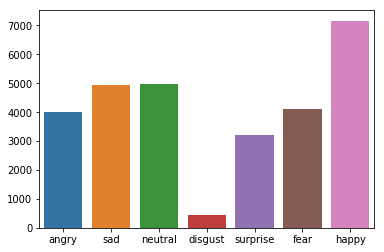

In [4]:
categories_images_count = {}

for category in categories:
    count = len([name for name in os.listdir(base_path+"/train/"+category)])
    categories_images_count[category] = count
    
sns.barplot(categories_images_count.keys(), categories_images_count.values());

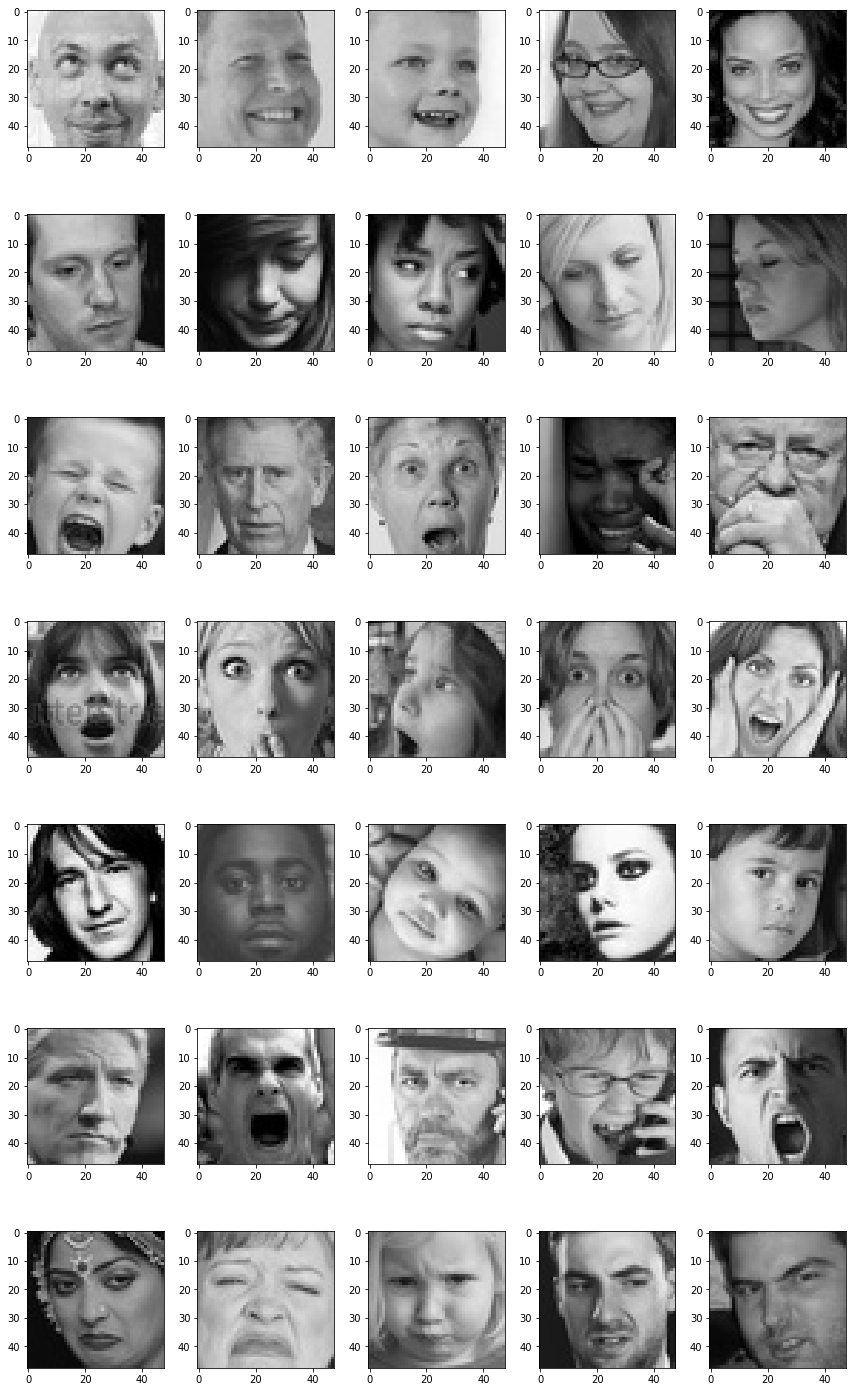

In [5]:
plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [6]:
# Prepare data generators to create batches

batch_size = 128

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(base_path + "train",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
label_map = (train_generator.class_indices)
print(label_map)

validation_generator = validation_datagen.flow_from_directory(base_path + "validation",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

label_map = (validation_generator.class_indices)
print(label_map)

Found 28821 images belonging to 7 classes.
{'angry': 0, 'sad': 5, 'neutral': 4, 'disgust': 1, 'surprise': 6, 'fear': 2, 'happy': 3}
Found 7066 images belonging to 7 classes.
{'angry': 0, 'sad': 5, 'neutral': 4, 'disgust': 1, 'surprise': 6, 'fear': 2, 'happy': 3}


In [63]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
%%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50
225/225 [==============================] - 538s 2s/step - loss: 2.0553 - accuracy: 0.2163 - val_loss: 3.2255 - val_accuracy: 0.2592

Epoch 00001: val_accuracy improved from -inf to 0.25923, saving model to model_weights.h5
Epoch 2/50
225/225 [==============================] - 532s 2s/step - loss: 1.9118 - accuracy: 0.2439 - val_loss: 3.4215 - val_accuracy: 0.2645

Epoch 00002: val_accuracy improved from 0.25923 to 0.26449, saving model to model_weights.h5
Epoch 3/50
225/225 [==============================] - 580s 3s/step - loss: 1.8561 - accuracy: 0.2639 - val_loss: 2.6499 - val_accuracy: 0.3024

Epoch 00003: val_accuracy improved from 0.26449 to 0.30239, saving model to model_weights.h5
Epoch 4/50
225/225 [==============================] - 540s 2s/step - loss: 1.8134 - accuracy: 0.2825 - val_loss: 2.3282 - val_accuracy: 0.3285

Epoch 00004: val_accuracy improved from 0.30239 to 0.32848, saving model to model_weights.h5
Epoch 5/50
225/225 [==============================] - 6

225/225 [==============================] - 736s 3s/step - loss: 1.1359 - accuracy: 0.5669 - val_loss: 0.6414 - val_accuracy: 0.6019

Epoch 00038: val_accuracy improved from 0.59152 to 0.60190, saving model to model_weights.h5
Epoch 39/50
225/225 [==============================] - 764s 3s/step - loss: 1.1271 - accuracy: 0.5704 - val_loss: 1.0425 - val_accuracy: 0.5600

Epoch 00039: val_accuracy did not improve from 0.60190
Epoch 40/50
225/225 [==============================] - 660s 3s/step - loss: 1.1296 - accuracy: 0.5668 - val_loss: 1.5220 - val_accuracy: 0.6090

Epoch 00040: val_accuracy improved from 0.60190 to 0.60897, saving model to model_weights.h5
Epoch 41/50
225/225 [==============================] - 646s 3s/step - loss: 1.1136 - accuracy: 0.5751 - val_loss: 1.8092 - val_accuracy: 0.6121

Epoch 00041: val_accuracy improved from 0.60897 to 0.61214, saving model to model_weights.h5
Epoch 42/50
225/225 [==============================] - 805s 4s/step - loss: 1.1117 - accuracy: 0.5

In [65]:
# Save model as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [66]:
# visualise training and testing accuracy and loss

def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
# print best epoch with best accuracy on validation

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

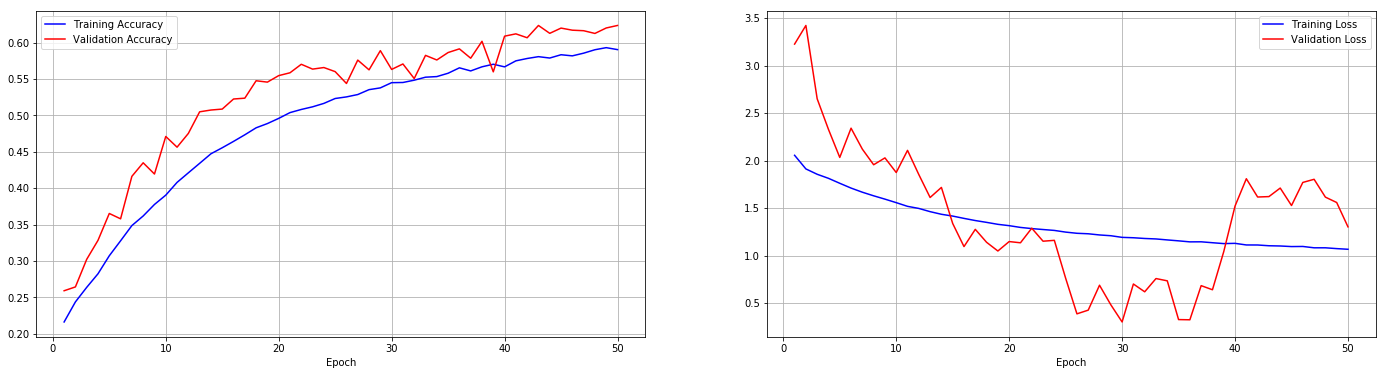

Best Validation Accuracy Score 0.62367, is for epoch 43


In [67]:
plot_results(history)
best_epoch = get_best_epcoh(history)

In [1]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

NameError: name 'model' is not defined